In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
from scipy.spatial import KDTree
from sklearn.cluster import KMeans
import numpy as np
from pyproj import Proj, transform

In [3]:
# Import the data for the location of the buildings
df_build = pd.read_csv("../Data/Chauderon_Buildings.csv")
loc_build = df_build[["id_building","x","y","transformer"]] #cleaner version of df_build

In [4]:
#Import geolocalisation of the grid buses
bus_data = pd.read_csv("../Data/Bus_632_location.csv")
bus_data = bus_data.sort_values(by="osmid").reset_index(drop=True)
bus_data["osmid"] += 1

# Define source (WGS84) and target projection (example: Swiss projection CH1903+ / LV95 EPSG:2056)
source_proj = Proj(proj="latlong", datum="WGS84")  # Geographic (latitude, longitude)
target_proj = Proj("epsg:2056")  # Swiss coordinate system

# Transform to projected coordinates
bus_data["x"], bus_data["y"] = transform(source_proj, target_proj, bus_data.longitude, bus_data.latitude)

# Bus geodata is the final dataframe that contains location
bus_geodata = bus_data.rename(columns={"osmid":"bus_id"})

C:\Users\antoi\AppData\Local\Temp\ipykernel_39920\2959377243.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bus_data["x"], bus_data["y"] = transform(source_proj, target_proj, bus_data.longitude, bus_data.latitude)


In [5]:
#node coords for NN
kdtree_bus = KDTree(bus_geodata[["x","y"]].values)

### Other Method : KNN clustering

With the first 2 techniques used, we only had 8 clusters, which doesn't match reality and/or data from swiss PDG that have 98 buses with demand. Therefore a KNN approach is used to get the clusters corresponding to the actual number of clusters

In [6]:
# Step 1: Create a new column to keep track of whether a point is close to any bus
def is_within_distance(point, buses, max_distance):
    for _, bus in buses.iterrows():
        distance = np.sqrt((point['x'] - bus['x']) ** 2 + (point['y'] - bus['y']) ** 2)
        if distance <= max_distance:
            return True
    return False

In [7]:
# Filter out all buildings that are more than "max_distance" away from one grid node.
KNN_build = loc_build.copy()
max_distance = 200  # 100 meters
KNN_build['close_to_bus'] = KNN_build.apply(is_within_distance, buses=bus_geodata, max_distance=max_distance, axis=1)
KNN_build = KNN_build[KNN_build['close_to_bus']].drop(columns='close_to_bus')

In [8]:
# Use KNN networks to cluster Buildings together
# Use of 98 clusters because in the original data 98 Buses had demand. --> allows the data to be in the same range
kmeans = KMeans(n_clusters=98, random_state=0)

KNN_build['cluster_id'] = kmeans.fit_predict(KNN_build[["x","y"]].values)

centroids = kmeans.cluster_centers_
KNN_df = pd.DataFrame(centroids, columns=['x', 'y']) #Give location of the centroids of the clusters
KNN_df['cluster_id'] = KNN_df.index #create an id for each clusters

C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [9]:
# searching closest point for KNN
_, indices_KNN = kdtree_bus.query(KNN_df[['x', 'y']].values)
KNN_df['closest_node_id'] = bus_geodata.iloc[indices_KNN].bus_id.values

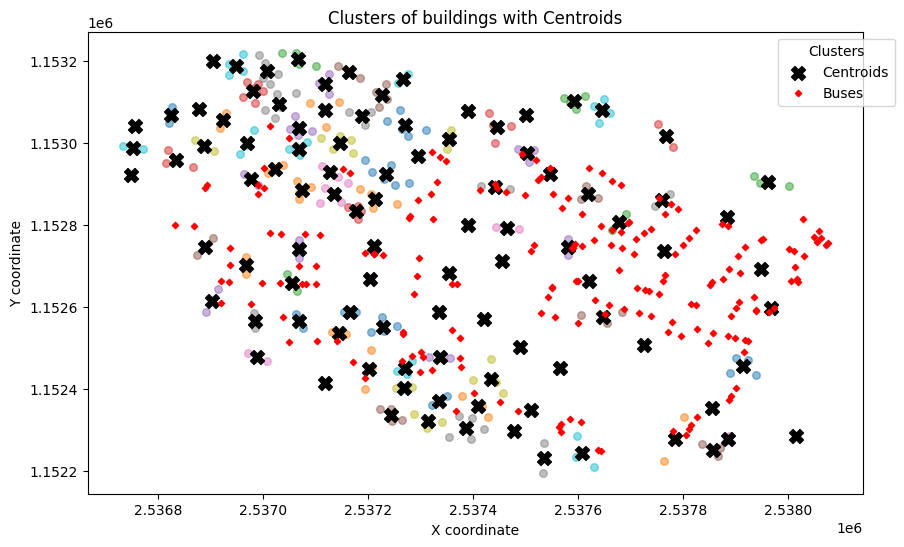

In [10]:
# Plot clusters 
plt.figure(figsize=(10, 6))

for cluster_id in KNN_df['cluster_id'].values:
    cluster_points = KNN_build[KNN_build['cluster_id'] == cluster_id]
    plt.scatter(cluster_points['x'], cluster_points['y'], s=30, alpha=0.5)#, label=f'Cluster {cluster_id}')

# Plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=100, label='Centroids')
plt.scatter(bus_geodata.x, bus_geodata.y, c='red', marker='D', s=10, label='Buses')


# Customizing the plot
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Clusters of buildings with Centroids')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title="Clusters")  # Place the legend outside the plot
#plt.grid(True)
plt.show()

In [11]:
# Map the cluster_id to grid_node to apply in on each building:
Building_data_KNN = KNN_build.merge(KNN_df[['cluster_id', 'closest_node_id']],on='cluster_id', how='left').rename(columns={'closest_node_id': 'grid_node'}).drop(columns="transformer")
#Map the Id_building to Hub to get the name of the building in that dataset:
Building_data_KNN = Building_data_KNN.merge(df_build[['id_building','Hub']],on='id_building', how='left')

In [12]:
#Final visualisation of the data
Building_data_KNN

,id_building,x,y,cluster_id,grid_node,Hub
0,10,2537763.934,1152736.286,52,89,Building1
1,11,2537745.695,1152845.777,67,102,Building2
2,12,2537774.918,1152876.028,67,102,Building3
3,120,2537883.024,1152820.996,30,101,Building4
4,141,2537947.311,1152693.849,66,171,Building5
...,...,...,...,...,...,...
239,1903852,2537683.444,1152587.086,25,111,Building296
240,1903854,2537690.581,1152827.891,2,97,Building297
241,1903864,2537655.394,1152562.112,25,111,Building298
242,1903870,2537661.060,1153072.818,9,35,Building299


In [13]:
#Save as csv
# This file only links every building to its transformer 
Building_data_KNN.to_csv("../Data/building_data_KNN.csv",index=False)